In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import os

In [2]:
import matplotlib.pyplot as plt

*square_function* is a simple function that returns set of pair of $\{(x_i,y_i)\}_0^{\text{total_points}}$ points in the form of Python list which we will use to generate rest of the points by training our 1D - GAN Generator. Here we choose a simple function to test our genertor, let's say $f(x) = x^2$. $\dots (1)$

In [3]:
def square_function(start_point, end_point, total_points):
    sampled_x = np.random.rand(1, total_points)*(end_point - start_point) + start_point
    
    training_data = []
    for x_value in sampled_x:
        y_value = x_value**2
        
        training_data.append([x_value, y_value])
    
    return training_data

In [4]:
training_data = square_function(-1, 1, 500)

In [5]:
X, Y = training_data[0][0], training_data[0][1]

Below is the discrete scatter plot of all points ($500$ points) which was returend by the *square_function* below the cell $(1)$ above. Notice that all the points lie in the interval $[-1, 1]$, which is the input/output range of our Neural Net Activation functions - tanh, sigmoid, etc. in the end layer.

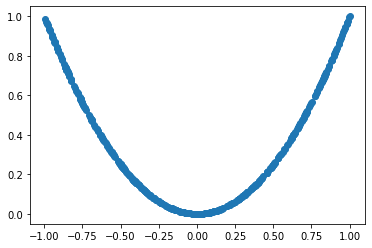

In [6]:
plt.scatter(X, Y)

We use the results from the original paper and use relu/tanh functions as our activation functions. We use 2 nodes from the front layer, out of total 10 to use as Input to the Neural Net.

In [7]:
generator = tf.keras.Sequential()
generator.add(tf.keras.layers.Input(2))
generator.add(tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_uniform'))
generator.add(tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_uniform'))
generator.add(tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_uniform'))
generator.add(tf.keras.layers.Dense(10, activation='tanh', kernel_initializer='he_uniform'))
generator.add(tf.keras.layers.Dense(2, activation='tanh', kernel_initializer='he_uniform'))
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 2)                 22        
                                                                 
Total params: 382
Trainable params: 382
Non-trainable params: 0
_________________________________________________________________


In [8]:
generator(tf.ones((1,2)))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.9265825 , 0.43858644]], dtype=float32)>

We use Sigmoid in the last layer of the discriminator function, so that we can use limit our output in the range $[0, 1]$. Here we'll use $0$ for labelling the output by Generator and $1$ for labelling the output by Generator

In [9]:
discriminator = tf.keras.Sequential()
discriminator.add(tf.keras.layers.Input(2))
discriminator.add(tf.keras.layers.Dense(10, activation='linear', kernel_initializer='he_uniform'))
discriminator.add(tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_uniform'))
discriminator.add(tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_uniform'))

In [10]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 10)                30        
                                                                 
 dense_6 (Dense)             (None, 10)                110       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [11]:
discriminator(tf.ones((1,2)))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.10837107]], dtype=float32)>

Now we create a joing GAN model by combining the output of generator and input of Discriminator. Notice, both of them have same dimensions. I'll shortly explain the mechaism of training in the later cells and the benefit we get by doing so.

In [12]:
GAN = tf.keras.Sequential([generator, discriminator])

In [13]:
GAN(tf.ones((1,2)))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.23483765]], dtype=float32)>

In [14]:
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 2)                 382       
                                                                 
 sequential_1 (Sequential)   (None, 1)                 151       
                                                                 
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


Here we use Adam Optimizer, which is known to speed up the training process and is a momentum based Neural Network training Optimizer.

In [15]:
GAN.layers[0].compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.002), metrics=['accuracy', 'mse'])
GAN.layers[1].compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.002), metrics=['accuracy', 'mse'])
GAN.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.002), metrics=['accuracy', 'mse'])

*generate_random_points* is a function to generate random noise values out of given range - *start* and *end*

In [16]:
def generate_random_points(start=-1, end=1):
    return np.random.rand(1,2)*(end - start) + start

Here, first we train Discriminator by Gradient Descedent and then, we train Generator by locking the Discriminator weights (setting *trainable* instance to *False*) and forcing GAN model to fool discriminator by outputting 1 by adjusting weights of only Generator!

In [17]:
def learning_step(dataset, GAN=GAN, epochs=500, batch_size=10):
    for epoch in range(epochs):
        for batch in range(batch_size):
            GAN.layers[0].trainable = False
            
            # 0 for fake points in discriminator 1 for real dataset points!
            GAN.layers[1].fit(generator(generate_random_points()), np.array([0]))
            
            print("batch :" + str(batch) + " epoch: " + str(epoch))
        GAN.layers[1].fit(dataset[epoch%500], np.array([1]))
        
        GAN.layers[1].trainable = False
        GAN.layers[0].trainable = True
        
        GAN.fit(generate_random_points(), np.array([1]))
        
        print("Epoch: " + str(epoch) + " Completed...")
        
        generated_values = []
        for _ in range(50):
            generated_values.append(GAN.layers[0](generate_random_points()))

        generated_values = np.array(generated_values)

        plt.scatter(dataset[:, 0, 0], dataset[:, 0, 1])
        plt.scatter(generated_values[:, 0, 0], generated_values[:, 0, 1], color=['red'])
        plt.show()
        plt.savefig(os.path.join("./folder/") + str(epoch)+ str('.png'))

In [18]:
GAN.layers[1](np.array([X[0], Y[0]]).reshape(1,2))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.3125161]], dtype=float32)>

In [19]:
dataset=[]
for i in range(500):
    dataset.append(np.array([X[i], Y[i]]).reshape(1,2))

In [20]:
dataset = np.array(dataset)

In [21]:
dataset.shape

(500, 1, 2)

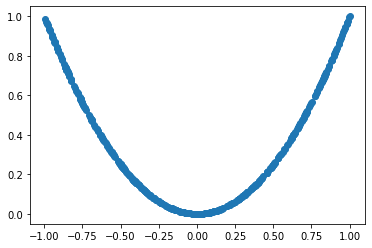

In [22]:
plt.scatter(dataset[:, 0, 0], dataset[:, 0, 1])

In [23]:
GAN.layers[0](generate_random_points())

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.054892 , 0.4703758]], dtype=float32)>

We notice a slow convergence by our Model (Generator) to the desired function, bit by bit with each epoch. 
Notice: 

1. Higher Momentum Rate ($\beta_1 >>$) by our Adam optimizer causes the points to lag to either extreme left or right and freeze there. It is known as mode collapse, where the output of generator freezes to a single vector and doesn't changes much despite input. A good remedy to it is a special GAN Model - DC GAN for images. 

2. Low learning rate ($\alpha << 0$) causes a certain randomness in the points which doesn't gets due to slow learning rate keeps jumping over the whole graph without converging. A effective remedy for such is to increase learning rate, but simultaneously decrease Momenum Rate.

In [ ]:
for i in range(1):
    
    #generate plots, then converge
    
    generated_values = []
    for _ in range(50):
        generated_values.append(GAN.layers[0](generate_random_points()))
    generated_values = np.array(generated_values)
    
    
    plt.scatter(dataset[:, 0, 0], dataset[:, 0, 1])
    plt.scatter(generated_values[:, 0, 0], generated_values[:, 0, 1], color=['red'])
    plt.show()
    
    
    #Train Networks
    
    learning_step(dataset, epochs=5000, batch_size=5)

In [25]:
discriminator(generator(generate_random_points()))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.23445815]], dtype=float32)>

Remarkable convergence, in just an hour of run by our 1D - GAN. For better results, usually 10 hours of training is preferred.

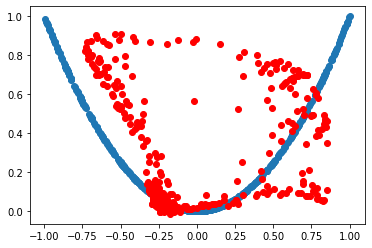

In [31]:
generated_values = []
for _ in range(400):
    generated_values.append(GAN.layers[0](generate_random_points()))

generated_values = np.array(generated_values)
plt.scatter(dataset[:, 0, 0], dataset[:, 0, 1])
plt.scatter(generated_values[:, 0, 0], generated_values[:, 0, 1], color=['red'])
plt.show()

<h1>Biblography</h1>

1. I. Goodfellow, J. Pouget-Abadie, M. Mirza, B. Xu, D. Warde-Farley,
S. Ozair, A. Courville, and Y. Bengio, “Generative adversarial nets,”
in Advances in Neural Information Processing Systems, 2014, pp.
2672–2680.

2. A. Radford, L. Metz, and S. Chintala, “Unsupervised representation learning with deep convolutional generative adversarial
networks,” in Proceedings of the 5th International Conference on
Learning Representations (ICLR) - workshop track, 2016.

3. Y. LeCun, Y. Bengio, and G. Hinton, “Deep learning,” Nature, vol.
521, no. 7553, pp. 436–444, 2015.

4. I. J. Goodfellow, “On distinguishability criteria for estimating generative models,” International Conference on Learning Representations - workshop track, 2015

5. I. Goodfellow, “Nips 2016 tutorial: Generative adversarial
networks,” 2016, presented at the Neural Information Processing
Systems Conference. [Online]. Available: https://arxiv.org/abs/1701.00160

6. J. D. Lee, M. Simchowitz, M. I. Jordan, and B. Recht, “Gradient
descent only converges to minimizers,” in Conference on Learning
Theory, 2016, pp. 1246–1257

7. Thanh-Tung, Hoang, and Truyen Tran. "Catastrophic forgetting and mode collapse in gans." 2020 international joint conference on neural networks (ijcnn). IEEE, 2020.

8. Kushwaha, Vandana, and G. C. Nandi. "Study of prevention of mode collapse in generative adversarial network (GAN)." 2020 IEEE 4th Conference on Information & Communication Technology (CICT). IEEE, 2020.
